Отобор признаков (**Feature Selection**) может понадобится, когда:
- Мы нагенерировали много фичей и нужно уменьшить их количество
- Есть ковариации в предикторах
- Некоторые фичи не обладают никакой предсказательной способностью и в модели они не нужны

Почему плохо когда слишком много предикторов:
- Долго обучаются модели
- Строк мало => появляется переобучение
- Модели становятся менее интерпертируемыми

-----

Значимость признаков (**Feature Importance**) - ранжирование признаков по вкладу в качество модели. 
Рассчитанные вклады признаков могут понадобиться:
- для понимания структуры модели
- как основа для последующего Feature Selection.

Под "качеством" признака понимается любая мера ассоциации признака с целевой переменной (например, корреляция,  коэффициент регрессии или что-либо ещё), либо вклад признака в качество модели.

-----

Есть несколько стандартных стратегий для отбора признаков:
1. Univariate Feature Selection
       когда отдельно по каждому признаку рассчитывается его "качество" и отбираются наиболее сильные признаки
2. Recursive Feature Elimination
       когда ищем оптимальную комбинацию признаков
3. Feature Importance Selection
       когда качество считается по каждому признаку, но не отдельно, а в результате обучения модели на всех признаках

RFE в отличие от UFS учитывает возможные зависимости между признаками!

-----

Далее рассмотрим подробнее каждый подход

## VarianceThreshold

Для начала можем удалить все фичи, которые являются констатами или очень мало изменяются

In [22]:
import pandas

data = [[0, 2, 0, 3], [0, 1, 4, 3], [0, 1, 1, 3]]
X = pandas.DataFrame(data, columns=['attr1','attr2','attr3','attr4'])

print(X)

   attr1  attr2  attr3  attr4
0      0      2      0      3
1      0      1      4      3
2      0      1      1      3


Изменяемость признака меряется его дисперсией (variance):
$$s_N = \sqrt {\frac{1}{N}\sum\limits_{i = 1}^N {\left( {x_i - \bar x} \right)^2 } }$$

Если дисперсия близка к нулю, признак вероятно бесполезен.

Параметр **threshold** задает минимально допустимое значение дисперсии признака.
Условие threshold = 0 соответствует детектированию констант.

In [26]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold = 0.0)

Для расчета дисперсий можем использовать метод fit()

In [17]:
selector.fit(X)
for feature_num, feature in enumerate(selector.variances_):
    print("Var(attr{})={}".format(feature_num,feature))

Var(attr0)=0.0
Var(attr1)=0.2222222222222222
Var(attr2)=2.888888888888889
Var(attr3)=0.0


Чтобы отфильтровать предикторы, применяем transform():

In [21]:
X_filtered = selector.transform(X)
print(X_filtered)

[[2 0]
 [1 4]
 [1 1]]


## Univariate Feature Selection 

UFS - собирательтное название подходов, при которых для каждого признака считается некая мера его ассоциации с целевой переменной, а затем признаки сортируются по убыванию этой меры и фильтруются.

**Какие могут быть меры ассоциации:**
- Тест Хи-квадрат
- F-тест для регрессии
- F-тест для ANOVA
- Mutual Information
- AUC ROC
- Корреляция Пирсона
- $R^2$
- Любые другие

Помимо самого значения теста (score) всегда учитываться ещё и достоверность ассоциации в виде соотвествующей p-value (вероятности ошибки I рода). Как правило, предельно допустимую p-value ставят равной 0.01-0.05 и этот параметр называется alpha.

**Какие есть способы отбора:**
- SelectKBest 
        выбираем k лучших признаков
- Select Percentiles 
        выбираем top-n % лучших признаков
- SelectFpr
        выбираем признаки со статистически значимой зависимостью (False Positive Rate)
- SelectFdr 
        выбираем признаки со статистически значимой зависимостью (False Discovery Rate)
- SelectFwe
        выбираем признаки признаки со статистически значимой зависимостью с помощью Family-wise Error Rate
- SelectFromModel
        выбираем признаки, которые некоторый внешний классификатор отметил как важные

**Чуть подробнее о FPR, FDR и FWE**

Задача - выбрать значимые признаки. Если на самом деле признак незначим, имеет место ложное срабатывание.
Поскольку признаков несколько, есть разные стратегии отобора.
- Family-wise: выбираем признаки так, чтобы вероятноть ложного срабатывания по каждому признаку была меньше заданного порога alpha
- FPR: выбираем набор признаков, у которого вероятность ложного срабатывания меньше alpha (то есть есть хотя один ложное срабатывание)
- FDR: процедура, допускающая определенную долю ложных срабатываний

Подробнее по различным мерам ассоциации

**Мера Хи-квадрат**

Определяет меру зависимости между категориальным признаком и категориальной целевой переменной

|Feature|Target|
|---|---|
|categorical|categorical|

Идея: если никакой зависимости между ними нет, то в рамках каждой категории признака целевая переменная должна быть  распределена одинаково. 

Тест Хи-квадрат численно измеряет наличие неравномерностей в таком распределении.

Как работает $\chi^2$?

Рассмотрим Contingency Table (таблицу сопряженности). По строкам - признак (во что играют на вечеринке), по столбцам целевая перемнная (что едят во время игры).

<img src="img/contingency_table.png" width=500>

Если y никак не зависит от X, то мы ожидаем в каждой ячейке увидеть такое количество наблюдений:

$$E_{ij} = \frac{row\_total \cdot column\_total}{global\_total}$$

Посчитаем, насколько ожидание отличается от реальности:

$$\tilde{\chi}^2=\frac{1}{d}\sum_{i} \sum_{j} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}\$$

где:
- $O_{ij}$ (observed) - наблюдаемое количество кейсов в ячейке (i,j), 

- $E_{ij}$ (expected) - ожидаемое количество кейсов в ячейке (i,j)


Теперь нужно проверить значимость полученного различия (ведь оно могло получиться большим случайно). 

Для этого анализируем распределение $\chi^2$: выбираем допустимую вероятность ошибки alpha и сравниваем с ней p-value нашего теста. Считаем, что различие значимо, если наблюдаемый p-value для распределения Хи-квадрат меньше порогового.

-----

**F-test для регрессии**

Определяет меру зависимости между числовым признаком и числовой целевой переменной

|Feature|Target|
|---|---|
|numeric|numeric|

Мы строим регрессию отдельно на каждом признаке (Target ~ Feature) и проверяем нулевой ли коэффициент у этой регрессии. Нулевой коэффициент говорит о том, что зависимости нет.

В регрессионном анализе классический тест для определения нулевого коэффициента - это <a href="https://en.wikipedia.org/w/index.php?title=Lack-of-fit_sum_of_squares#The_test_statistic">F-тест</a> Фишера.

Как считается F-тест:
1. SSM = $\sum{(\hat{y}-\bar{y})^2}$ - сумма квадратов отклонений регресии от среднего значения


2. SSE = $\sum{\epsilon} = \sum{(\hat{y}-y)^2}$ - сумма квадратов ошибок регрессии

    Хотим проверить: Если магнитуда отклонений регрессии примерно равна магнитуде ошибок, значит вся вариация данных объясняется только случайными ошибками и целевая переменная не зависит от признака.


3. Нормируем каждую сумму числом степеней свободы и считаем F-статистику


$$F = \frac{SSM / (p-1)}{SSE / (n - p)}$$

    Рассчитанная статистика имеет распределние Фишера. Распределение Фишера выглядит примерно так:

   <img src="img/f.gif">

4. Задаем alpha - допустимую веротяность ошибки I рода (ложного срабатывания). Как правило, это 5% или 1%.

    То есть не чаще чем 1 раз за 20 экспериментов, тест будет показывать зависимость, когда её на самом деле нет.


5. Определяем p-value для нашего теста. Если оно больше максимально допустимого, то целевая переменная не зависит от признака. 


-----

**F-test для классификации**

Определяет меру зависимости между числовым признаком и категориальной целевой переменной

|Feature|Target|
|---|---|
|numeric|categorical|


Если зависимости нет, средние значение признака по каждому классу должны быть одинаковыми

Для проверки равенства средних значений используется F-статистика

Математически:
$$F = \frac{MS_b}{MS_w}$$

-----

**Mutual Information**

Mutual Information - статистическая мера зависимости между двумя случайными величинами

Определяет меру зависимости между любым признаком и любой целевой переменной

|Feature|Target|
|---|---|
|any|any|

Идея: если зависимости нет, условное распределение одной переменной P(y|x) не должно зависеть от распределения второй переменной, то есть P(y|x) должна быть равна P(y).

В отличие от корреляции, которая детектирует только линейную зависимость, MI ловит любые зависимости.

Математически:

$$I(X,Y) = \sum_y \sum_x P(x,y) \log{\frac{P(x,y)}{P(x)P(y)}}$$

Видим, что $\frac{P(x,y)}{P(x) \cdot P(y)} = \frac{P(y | x)}{P(y)}$, то есть просто показатель, как сильно значение X меняет распределение целевой переменной y.

Затем эти штуки суммируются по всем значениям x и y, с учетом популярности этих значений P(x,y) и получаем меру взаимной информации I(x,y).

Легко видеть, что если X и Y независимы (и P(x,y)=P(x)P(y)), то MI = 0

На практике формулами посчитать не можем, поэтому считается итерационным алгоритмом Mutual Information

-----

**AUC ROC**


Определяет меру зависимости между числовым признаком и бинарной целевой переменной

|Feature|Target|
|---|---|
|numeric|binary|


Считаем ROC AUC как обычно, но в качестве скорингового бала используем значения признака. Если зависимости между признаком и целевой переменной нету, ROC AUC = 0.5. Если признак можно использовать для полного разделения двух классов, то ROC AUC = 1.0.

Как считается ROC AUC?

Простейший классификатор - взять признак  и определить его пороговое значение - все, что выше относим к классу "1", все что ниже, относим к классу "0".

У такого классификатора считаем Recall (долю верно классифицируемого класса "1") и Specificity (долю верно классифицируемого класса "0") и отмечаем точку на ROC-плоскости.
<img src="img/roc1.png" width=400>

Меняя порог от 0.0 до 1.0, получаем множество классификаторов и, как следствие, непрерывную ROC-кривую

<img src="img/roc2.png" width=300>

Площадь под этой кривой ROC AUC - мера разделимости двух классов данной моделью.

-----

**Корреляция Пирсона**

Определяет меру зависимости между числовым признаком и числовой целевой переменной

|Feature|Target|
|---|---|
|numeric|numeric|

Классическая мера, известная всем.
$$Corr(X,Y) = \frac{E[(X-\bar{X})(Y-\bar{Y})]}{E[(X-\bar{X})^2]E[(Y-\bar{Y})^2]}$$

-----

**Статистика $R^2$**

Определяет меру зависимости между числовым признаком и бинарной целевой переменной

|Feature|Target|
|---|---|
|numeric|numeric|

Можно обратить внимание, что почти полностью повторяет описанный выше F-тест Фишера для регрессии.

$$R^2 = \frac{SSM}{SSE}$$

-----

Для начала рассчитаем F-статистику для числовых признаков

In [47]:
from sklearn.datasets import load_iris

df = load_iris()
X, y = df['data'], df['target']

from sklearn.feature_selection import f_regression
scores, pvalues = f_regression(X,y)

for num, (s,p) in enumerate(zip(scores,pvalues)):
    print("Feature{}: F-test score={}, p-value={}\n".format(num,round(s,2),p))

Feature0: F-test score=233.84, p-value=2.8904783526016577e-32

Feature1: F-test score=32.94, p-value=5.201563255171195e-08

Feature2: F-test score=1341.94, p-value=4.2018731529488986e-76

Feature3: F-test score=1592.82, p-value=4.1553110153134456e-81



Тут все атрибуты значимы. Попробуем другой датасет, он поменьше => p-value будут больше.

In [66]:
from sklearn.datasets import load_linnerud
df = load_linnerud()
X, y = df['data'], df['target'][:,0]
scores, pvalues = f_regression(X, y)

for num, (s,p) in enumerate(zip(scores,pvalues)):
    print("Feature{}: F-test score={}, p-value={}\n".format(num,round(s,2),p))

Feature0: F-test score=3.22, p-value=0.08942226312017666

Feature1: F-test score=5.78, p-value=0.027167887465660654

Feature2: F-test score=0.97, p-value=0.337364665679547



Создадим селектор на базе данной статистики

In [106]:
from sklearn.feature_selection import SelectFdr, SelectFpr, SelectFwe
feature_selector = SelectFpr(score_func=f_regression, alpha=0.05)
feature_selector.fit(X,y)

SelectFpr(alpha=0.05, score_func=<function f_regression at 0x1a1afe7048>)

Выведем, что он насчитал.

In [107]:
print(feature_selector.pvalues_)
print(feature_selector.scores_)

[0.08942226 0.02716789 0.33736467]
[3.22293987 5.78220199 0.97152578]


In [109]:
Xnew = feature_selector.fit_transform(X,y)
Xnew.shape

(20, 1)

Видим, что селектор отфильтровал два признака со слишком большими p-values

Попробуем отфильтровать признаки с помощью chi2

In [144]:
from sklearn.datasets import load_wine
df = load_wine()
X,y = df['data'], df['target']

import pandas
pandas.DataFrame(X, columns = df['feature_names']).head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [145]:
from sklearn.feature_selection import SelectKBest, chi2

feature_selector = SelectKBest(score_func=chi2, k=5)
feature_selector.fit(X,y)
Xnew = feature_selector.transform(X)

Xnew.shape

(178, 5)

Посмотрим, какие признаки оставил селектор

In [149]:
feature_names = pandas.Series(df['feature_names'])
feature_names[feature_selector.get_support()]

3     alcalinity_of_ash
4             magnesium
6            flavanoids
9       color_intensity
12              proline
dtype: object

## Recursive Feature Elimination

RFE - поиск оптимального набора предикторов путем последовательного удаления "плохих" фичей из перовначального набора. 

Для оценки качества фичей используется любой классификатор, который возвращает списком величину вклада предкитора в качество модели.

В Sklearn за это отвечает класс RFE

In [6]:
from sklearn.feature_selection import RFE

Основные параметры класса RFE:
- estimator - классификатор
- n_features_to_select - какое число признаков нужно в итоге отобрать
- step - сколько признаков убирать из набора на каждом шаге

In [ ]:
from sklearn.svm import SVR
svc = SVR(kernel="linear")
rfecv = RFECV(estimator=svc, n_features_to_select = 10, step=1)

Для определения требуемого кол-ва фичей можно воспользоваться удобным методом RFECV.

Метод делает то же самое, что GridSearchCV, но сетка параметров и содержит различные кол-ва признаков [1,2 ... k]

In [ ]:
from sklearn.feature_selection import RFECV

Основные параметры:
- estimator - классификатор
- cv - параметры кросс-валидации
- scoring - метрика для оценки качества признаков

In [5]:
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy')

Можем построить график точности классифкатора в зависимости от числа признаков:

In [7]:
%matplotlib

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
                           n_redundant=2, n_repeated=0, n_classes=8,
                           n_clusters_per_class=1, random_state=0)

svc = SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Using matplotlib backend: Qt5Agg
Optimal number of features : 3


Посмотрим, какие признаки мы в итоге отобрали

In [12]:
rfecv.support_

array([False,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False])

Также можем проследить, в каком порядке убирались признаки. Индекс 1 соотвествует отобранным в итоге признакам.

In [11]:
rfecv.ranking_

array([ 5,  1, 12, 19, 15,  6, 17,  1,  2, 21, 23, 11, 16, 10, 13, 22,  8,
       14,  1, 20,  7,  9,  3,  4, 18])

## Feature Importance

Многие алгоритмы (в том числе RanfomForest и XGBoost) в процессе обучения модели также рассчитывают Feature Importance по всем предикторам. Эти feature importances также можно использовать для отбора признаков.

В Sklearn за это отвечает метод SelectFromModel

**Что для этого нужно?**

Классификатор должен возвращать либо атрибут coef_, либо атрибут feature_importance_

Какие есть классификаторы, удовлетворяющие этому требованию:

- ансамбли деревьев
    - RandomForestClassifier
    - ExtraTreesClassifier
    
- линейные модели с коэффициентами
    - LogisticREgression
    - LinearRegression

- модели с L1-регуляризацией
    - LinearSVC
    - Lasso

## L1-регуляризация

Зануление некоторых коэффициентов - часть процесса L1-регуляризации в линейных моделях. Следовательно его можно использовать для отбора признаков.

Чем больше мы поставили коэффициент регуляризации, тем больше коэффициентов зануляется, и тем меньше ненулевых признаков в модели.

Опция prefit=True означает, что модель уже обучена и ещё раз ее запускать не нужно.

In [5]:
from sklearn.feature_selection import SelectFromModel

# Load some data
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

# Lets make classifer
from sklearn.svm import LinearSVC
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)

model = SelectFromModel(estimator = lsvc, prefit=True)

Применяя метод transform() мы отфильтровываем часть плохих признаков.

In [11]:
Xnew = model.transform(X)
Xnew.shape

(150, 3)

## RandomForest Feature Importance

Случайный лес считает важность признаков в процессе обучения.

Случайный лес состоит из большого количества решающих деревьев. Все деревья разные, так как при построении дерева признак для очередного разбиения выбирается в определнной степени случайно.

Важность признака в RandomForest определяется через то, как часто признак участвует в разбиениях. Чем чаще он используется и чем ближе находится разбиение к корню, тем важнее признак.

In [59]:
from sklearn.feature_selection import SelectFromModel

# Load some data
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

# Lets make classifer
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X, y)

/Users/Konstantin/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Посмотрим, что алгоритм насчитал в качестве важности признаков

In [61]:
for colnum, colname in enumerate(iris['feature_names']):
    print("Feature{} importance = {}".format(colnum, round(rf.feature_importances_[colnum],5)))

Feature0 importance = 0.0732
Feature1 importance = 0.02227
Feature2 importance = 0.38004
Feature3 importance = 0.52449


По умолчанию SelectFromModel выбирает все, что выше медианы (то есть половину признаков).

In [43]:
Xnew = model.transform(X)
Xnew.shape

(150, 2)

Порог можно поставить и вручную параметром threshold

In [44]:
model = SelectFromModel(estimator = rf, prefit=True, threshold = 0.1)
Xnew = model.transform(X)
Xnew.shape

(150, 3)

Ещё его удобно определять визуально

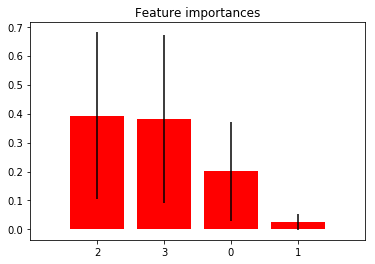

In [49]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_

# Отсортируем по убыванию значиомсти
indices = np.argsort(importances)[::-1]

# Посчитаем стандартное отклонение (ошибку) значимости
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])

plt.show()

*Ошибка большая из-за того, что датасет маленький

Возьмем например всё, что выше 0.25

In [56]:
select_transformer = SelectFromModel(estimator = rf, threshold = 0.25, prefit=True)
Xnew = select_transformer.transform(X)
Xnew.shape

(150, 2)

In [16]:
Xnew.shape

(150, 2)